In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchvision import transforms, utils,datasets
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import glob

##### Define data paths

In [2]:
#get all image and mask paths
image_paths = glob.glob("C:\\Users\\Alexandra\\Desktop\\thesis\\7_week\\topostruct\\data\\img\\*.jpg")
mask_paths = glob.glob("C:\\Users\\Alexandra\\Desktop\\thesis\\7_week\\topostruct\\data\\msk\\*.jpg")

#split paths
len_images = len(image_paths)
print(len_images)
train_size = 0.6

#length of image and mask folder is the same
train_image_paths = image_paths [:int(len_images*train_size)]
test_image_paths = image_paths[int(len_images*train_size):]

train_mask_paths = mask_paths [:int(len_images*train_size)]
test_mask_paths = mask_paths[int(len_images*train_size):]


15


In [ ]:
torch.set_printoptions(profile="full")

##### Custom dataset

In [3]:
#dataset class
class image_dataset(Dataset):
    def __init__(self, images, masks, train=True):
        self.images = images
        self.masks = masks
#         self.num_classes = num_classes
#         self.transforms = transforms

    def transform(self, image,mask):
        resize_im = transforms.Resize(size = (256,256), interpolation=Image.NEAREST)
        resize_m = transforms.Resize(size = (256,256), interpolation=Image.NEAREST)
        gray =  transforms.Grayscale(num_output_channels=1)
        
        image = resize_im(image)
        mask = resize_m(mask)
        
        image = gray(image)
        mask = gray(mask)
        
        
        ####
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        mask = mask.__ge__(0.7).type(torch.FloatTensor) 
        return image,mask
        
    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        mask = Image.open(self.masks[idx])        
        x,y = self.transform(image,mask)
        return x,y
        
    def __len__(self):
        return len(self.images)


In [4]:
train_data = image_dataset(train_image_paths, train_mask_paths, train=True)
train_loader = DataLoader(train_data, batch_size = 3, shuffle = True)

test_data = image_dataset(test_image_paths, test_mask_paths, train = False)
test_loader = DataLoader(test_data, batch_size = 3, shuffle = False)

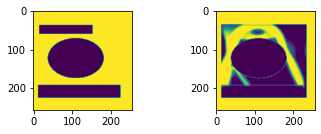

torch.Size([1, 256, 256])


In [5]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(train_data[0][1][0])
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(train_data[0][0][0])
plt.show()
#print(train_data[1][1])
print(train_data[0][0].shape)

In [6]:
# Use gpu for training if available else use cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
def Conv_double(in_chans, out_chans):
    conv = nn.Sequential(
        nn.Conv2d(in_chans,out_chans, kernel_size =3,padding =1),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_chans, out_chans, kernel_size =3,padding = 1),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace=True)
    )
    return conv

def Crop_tensor(source, target):
    target_size = target.size()[2]
    source_size = source.size()[2]
    d = source_size - target_size
    if d>1:
        d = (int)(d // 2)
        return source[:,:,d:source_size-d, d:source_size-d]
    else:
        return source[:,:,d:source_size, d:source_size]

In [8]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size =2, stride =2)
        
        #convolutions
        self.down_conv1 = Conv_double(1,64)
        self.down_conv2 = Conv_double(64, 128)
        self.down_conv3 = Conv_double(128, 256)
        self.down_conv4 = Conv_double(256, 512)
        self.down_conv5 = Conv_double(512, 1024)
        
        #up-convolutions
        self.conv_trans1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size=2, stride=2)
        self.up_conv1 = Conv_double(1024, 512)
        
        self.conv_trans2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size=2, stride=2)
        self.up_conv2 = Conv_double(512, 256)
        
        self.conv_trans3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size=2, stride=2)
        self.up_conv3 = Conv_double(256, 128)
        
        self.conv_trans4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size=2, stride=2)
        self.up_conv4 = Conv_double(128, 64)
    
        #output
        self.out = nn.Conv2d(in_channels = 64, out_channels = 1,kernel_size=1)
        
    def forward(self, img):
        #bs,c,h,w
        #encoder
        x1 = self.down_conv1(img) #        
        x2 = self.maxpool(x1)
        x3 = self.down_conv2(x2)   #
        x4 = self.maxpool(x3)
        x5 = self.down_conv3(x4)   #
        x6 = self.maxpool(x5)
        x7 = self.down_conv4(x6)   #
        x8 = self.maxpool(x7)
        x9 = self.down_conv5(x8)   
        
        #decoder
        x = self.conv_trans1(x9)  
        #crop tensor
        y = Crop_tensor(x7, x)        
        #conacatenate
        x = self.up_conv1(torch.cat([x,y],1))
        
        x = self.conv_trans2(x)        
        y = Crop_tensor(x5, x)        
        x = self.up_conv2(torch.cat([x,y],1))
        
        x = self.conv_trans3(x)        
        y = Crop_tensor(x3, x)
        x = self.up_conv3(torch.cat([x,y],1))
        
        x = self.conv_trans4(x)        
        y = Crop_tensor(x1, x)
        x = self.up_conv4(torch.cat([x,y],1))
        
        x = self.out(x)
        
        return x
  

In [9]:
model = UNet()
model = model.to(device)
#print(model)

In [10]:
learning_rate = 0.001
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# The training loop
epochs = 500
total_steps = len(train_loader)
#print(f"{epochs} epochs, {total_steps} total_steps per epoch")
for epoch in range(epochs):
    for i, (images, masks) in enumerate(train_loader):

        images = images.to(device)
#        masks = masks.type(torch.LongTensor)
#        masks = masks.reshape(masks.shape[0], masks.shape[2], masks.shape[3])
        masks = masks.to(device)

        # Forward pass
        outputs = model(masks)
        
        softmax = torch.nn.functional.log_softmax(outputs, dim=1)
        loss = criterion(outputs, images)
       
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         
        if (i) % 100 == 0:
            print (f"Epoch [{epoch + 1}/{epochs}], Step [{i}/{total_steps}], Loss: {loss.item():4f}")

Epoch [1/500], Step [0/3], Loss: 0.726149
Epoch [2/500], Step [0/3], Loss: 0.466036
Epoch [3/500], Step [0/3], Loss: 0.446794
Epoch [4/500], Step [0/3], Loss: 0.407600
Epoch [5/500], Step [0/3], Loss: 0.397139
Epoch [6/500], Step [0/3], Loss: 0.352519
Epoch [7/500], Step [0/3], Loss: 0.339720
Epoch [8/500], Step [0/3], Loss: 0.344493
Epoch [9/500], Step [0/3], Loss: 0.320891
Epoch [10/500], Step [0/3], Loss: 0.312865
Epoch [11/500], Step [0/3], Loss: 0.310142
Epoch [12/500], Step [0/3], Loss: 0.276369
Epoch [13/500], Step [0/3], Loss: 0.285925
Epoch [14/500], Step [0/3], Loss: 0.279905
Epoch [15/500], Step [0/3], Loss: 0.273526
Epoch [16/500], Step [0/3], Loss: 0.284945
Epoch [17/500], Step [0/3], Loss: 0.244368
Epoch [18/500], Step [0/3], Loss: 0.237472
Epoch [19/500], Step [0/3], Loss: 0.255718
Epoch [20/500], Step [0/3], Loss: 0.229472
Epoch [21/500], Step [0/3], Loss: 0.253385
Epoch [22/500], Step [0/3], Loss: 0.252699
Epoch [23/500], Step [0/3], Loss: 0.244690
Epoch [24/500], Step

Epoch [190/500], Step [0/3], Loss: 0.144711
Epoch [191/500], Step [0/3], Loss: 0.136482
Epoch [192/500], Step [0/3], Loss: 0.129198
Epoch [193/500], Step [0/3], Loss: 0.106348
Epoch [194/500], Step [0/3], Loss: 0.132381
Epoch [195/500], Step [0/3], Loss: 0.108176
Epoch [196/500], Step [0/3], Loss: 0.128586
Epoch [197/500], Step [0/3], Loss: 0.090050
Epoch [198/500], Step [0/3], Loss: 0.126229
Epoch [199/500], Step [0/3], Loss: 0.105856
Epoch [200/500], Step [0/3], Loss: 0.105267
Epoch [201/500], Step [0/3], Loss: 0.088562
Epoch [202/500], Step [0/3], Loss: 0.118182
Epoch [203/500], Step [0/3], Loss: 0.099530
Epoch [204/500], Step [0/3], Loss: 0.104698
Epoch [205/500], Step [0/3], Loss: 0.104520
Epoch [206/500], Step [0/3], Loss: 0.098883
Epoch [207/500], Step [0/3], Loss: 0.101965
Epoch [208/500], Step [0/3], Loss: 0.106072
Epoch [209/500], Step [0/3], Loss: 0.084631
Epoch [210/500], Step [0/3], Loss: 0.122479
Epoch [211/500], Step [0/3], Loss: 0.108807
Epoch [212/500], Step [0/3], Los

Epoch [377/500], Step [0/3], Loss: 0.118707
Epoch [378/500], Step [0/3], Loss: 0.077268
Epoch [379/500], Step [0/3], Loss: 0.102216
Epoch [380/500], Step [0/3], Loss: 0.074569
Epoch [381/500], Step [0/3], Loss: 0.117256
Epoch [382/500], Step [0/3], Loss: 0.109210
Epoch [383/500], Step [0/3], Loss: 0.116455
Epoch [384/500], Step [0/3], Loss: 0.108658
Epoch [385/500], Step [0/3], Loss: 0.108677
Epoch [386/500], Step [0/3], Loss: 0.104811
Epoch [387/500], Step [0/3], Loss: 0.104071
Epoch [388/500], Step [0/3], Loss: 0.084419
Epoch [389/500], Step [0/3], Loss: 0.119551
Epoch [390/500], Step [0/3], Loss: 0.091927
Epoch [391/500], Step [0/3], Loss: 0.127394
Epoch [392/500], Step [0/3], Loss: 0.095180
Epoch [393/500], Step [0/3], Loss: 0.115912
Epoch [394/500], Step [0/3], Loss: 0.104377
Epoch [395/500], Step [0/3], Loss: 0.072805
Epoch [396/500], Step [0/3], Loss: 0.115623
Epoch [397/500], Step [0/3], Loss: 0.095553
Epoch [398/500], Step [0/3], Loss: 0.077753
Epoch [399/500], Step [0/3], Los

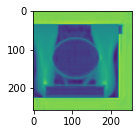

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(np.squeeze(outputs[2].cpu().detach().numpy()))
plt.show()

In [ ]:
images[0]

In [ ]:
out[0]

In [ ]:
criterion(out[0],images[0])

image shape: torch.Size([3, 1, 256, 256])
output shape: torch.Size([3, 1, 256, 256])


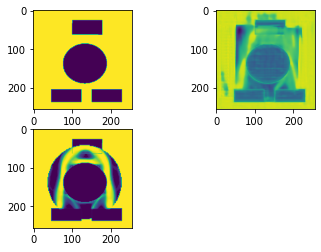

image shape: torch.Size([3, 1, 256, 256])
output shape: torch.Size([3, 1, 256, 256])


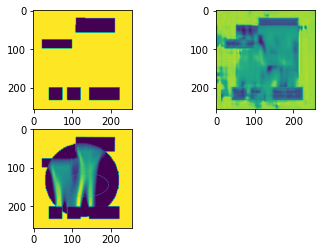

In [15]:
for i, (images, masks) in enumerate(test_loader):
    masks = masks.to(device)
    output = model(masks)
    
    print("image shape:", masks.shape)
    print("output shape:", output.shape)

    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(np.squeeze(masks[0].cpu().detach().numpy()))
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(np.squeeze(output[0].cpu().detach().numpy()))
    
    ax3 = fig.add_subplot(2,2,3)
    ax3.imshow(np.squeeze(images[0].cpu().detach().numpy()))
    
    plt.show()


In [ ]:
image = Image.open('test_textures/boat.jpg')
img = image.resize((300,300))
img = img.convert('L')
display(img)
print(img)
print(img.size)

#connvert to tensor
trans1 = transforms.ToTensor()
img = trans1(img).view(1,1,300,300)
print(img.shape)

In [ ]:
image = torch.rand((1,1,300,300))

In [ ]:
outputs = model(img.to(device))
img1 = np.squeeze(outputs[0].cpu().detach().numpy())
print(img1.shape)
plt.imshow(img1)
plt.show()


In [ ]:
img3 = np.squeeze(myImage.detach().numpy())
img3 = (img3)
print(img3.shape)
plt.imshow(img3)
plt.show()